In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from utils import *

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm

from darts.utils.statistics import check_seasonality
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

sns.set(font_scale=1)
sns.set_style('white')
sns.set_style('ticks')

2023-08-11 17:58:10 darts.models WARNING: The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


# Dataset 

In [14]:
data_dir = '../data'
data = pd.read_csv(os.path.join(data_dir,'perrin-freres-monthly-champagne.csv')).dropna(axis=0)
data.columns = ['Date', 'Sale']
data['Date'] = pd.to_datetime(data['Date'])
data['rolling_avg'] = data['Sale'].rolling(window=12).mean()
data['rolling_std'] = data['Sale'].rolling(window=12).std()
data = data.set_index('Date')

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sale         105 non-null    float64
 1   rolling_avg  94 non-null     float64
 2   rolling_std  94 non-null     float64
dtypes: float64(3)
memory usage: 3.3 KB
None


,Sale,rolling_avg,rolling_std
Date,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,NaN,NaN
1964-03-01,2755.0,NaN,NaN
1964-04-01,2721.0,NaN,NaN
1964-05-01,2946.0,NaN,NaN


# Seasonality and periodicity check

In [15]:
data['Date'] = data.index
series = TimeSeries.from_dataframe(data, 'Date', 'Sale')
is_seasonal, seq_len = check_seasonality(series, max_lag=240)
dict_seas ={'is seasonal?':is_seasonal, 'periodicity (months)':f'{seq_len:.1f}'}
_ = [print(k,':',v) for k,v in dict_seas.items()]

df, df_test = data.iloc[:data.shape[0]-2*seq_len, :], data.iloc[data.shape[0]-2*seq_len:, :]

is seasonal? : True
periodicity (months) : 6.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Sale         105 non-null    float64       
 1   rolling_avg  94 non-null     float64       
 2   rolling_std  94 non-null     float64       
 3   Date         105 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.1 KB


# Decomposition

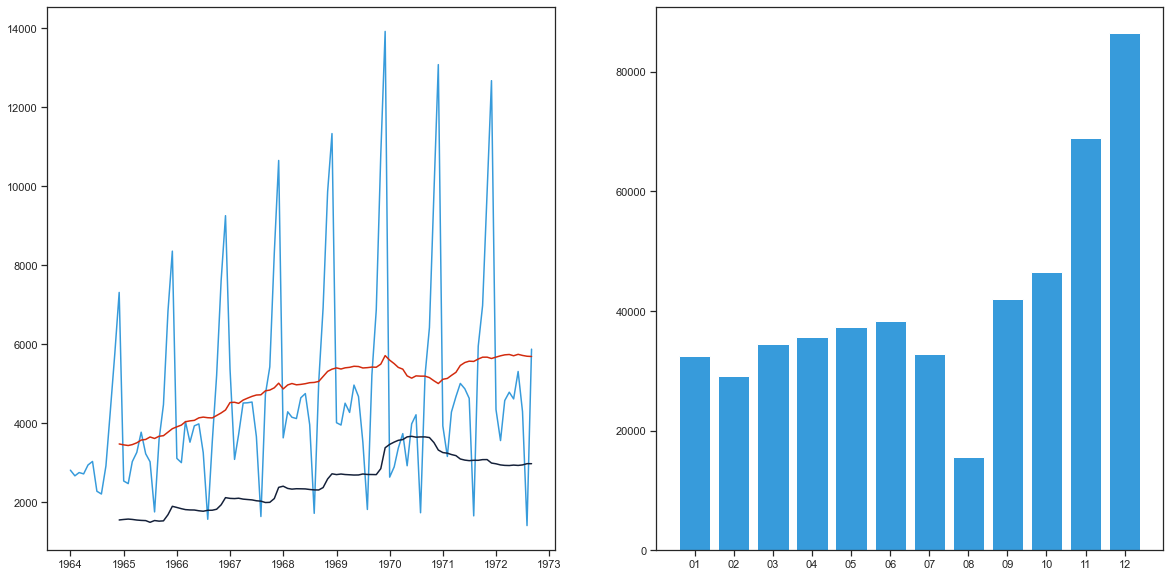

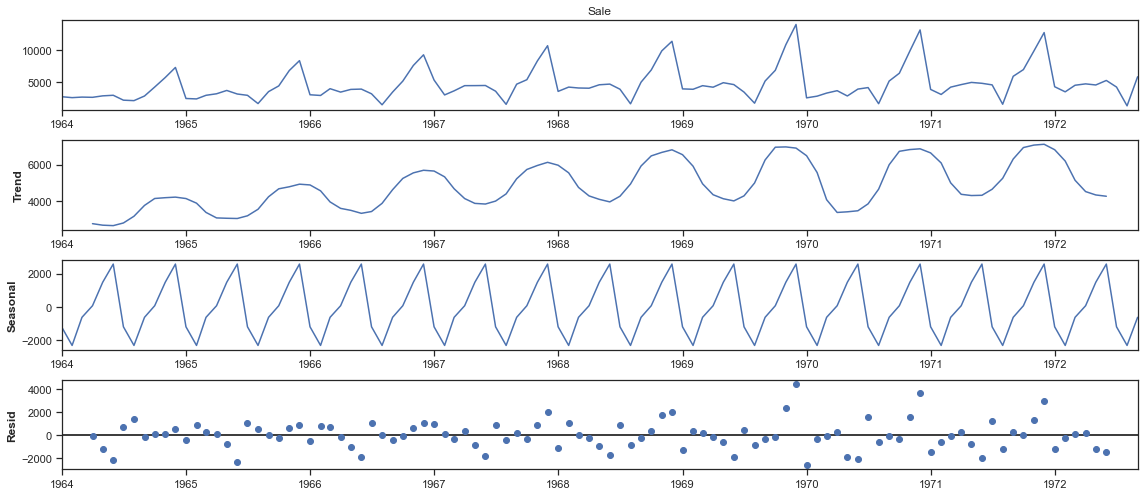

In [4]:
ssn = seasonal_decompose(data['Sale'], model='additive', period=seq_len)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(data['Sale'], color='#379BDB', label='Original')
plt.plot(data['rolling_avg'], color='#D22A0D', label='Rolling Mean')
plt.plot(data['rolling_std'], color='#142039', label='Rolling Std')
plt.subplot(1,2,2)
month = [str('%02d'%(i)) for i in range(1,13)]
cnt = [np.sum([r['Sale'] for idx, r in data.iterrows() if str(idx).split('-')[1]==d]) for d in month]# df['Sale'].values
plt.bar(month, cnt, color='#379BDB')

plt.rc('figure', figsize=(16, 7))
plt.rc('font', size=10)
fig = ssn.plot()
plt.show()

# Stationarity test

In [5]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['Sale'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


# Auto ARIMA / SARIMA / SARIMAX approach

In [6]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Sale'], 
                            start_p=1, 
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

SARIMA_model = pm.auto_arima(df['Sale'], start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, 
                             m=12, #12 is the frequncy of the cycle
                             start_P=0, 
                             seasonal=True, #set to seasonal
                             d=None, 
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

#adding exogenous variable
df['month_index'] = df.index.month
SARIMAX_model = pm.auto_arima(df[['Sale']],
                              exogenous=df[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1, 
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

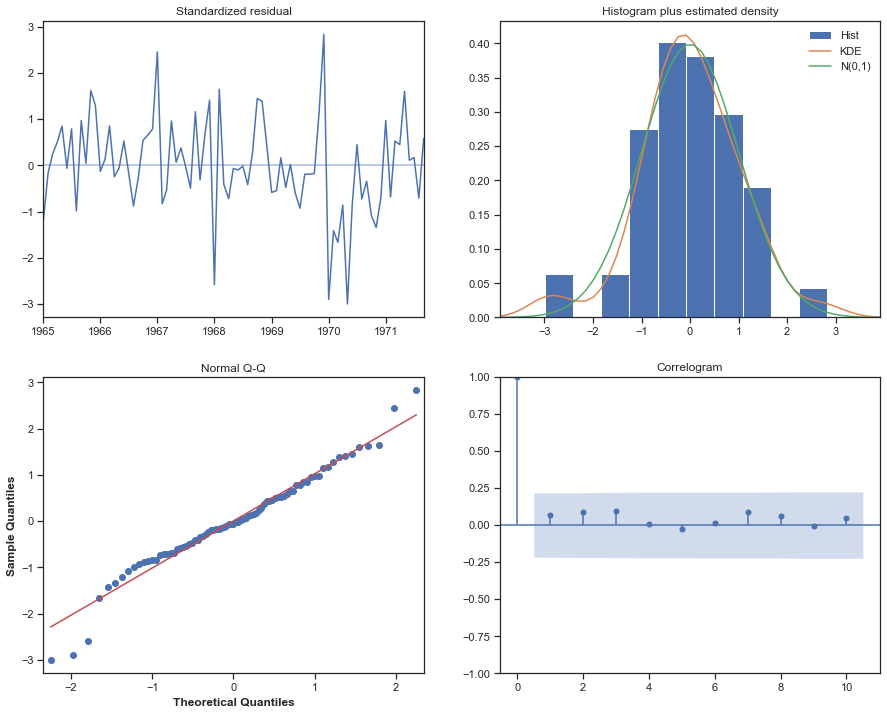

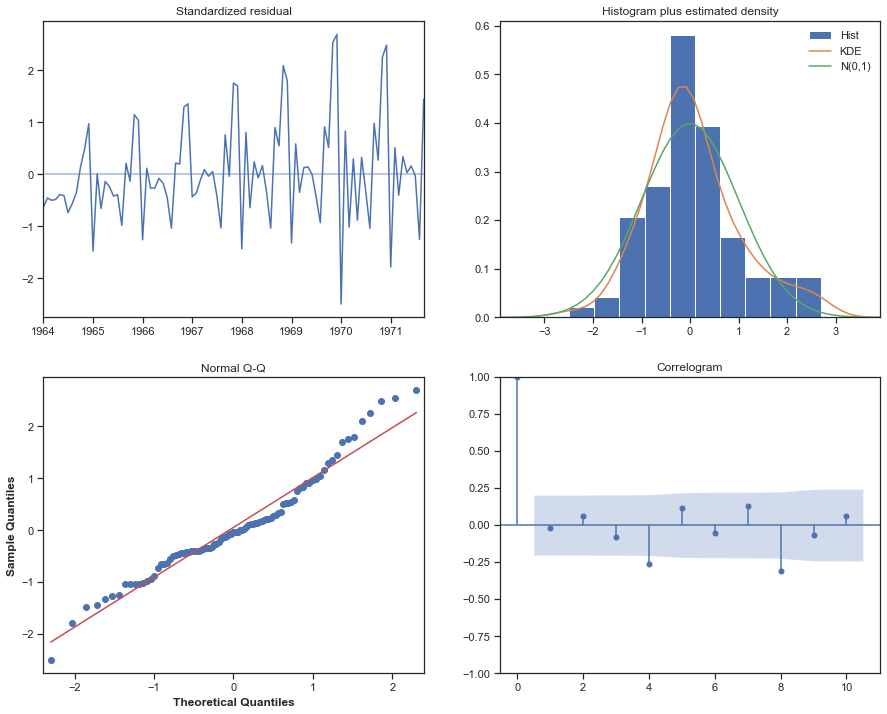

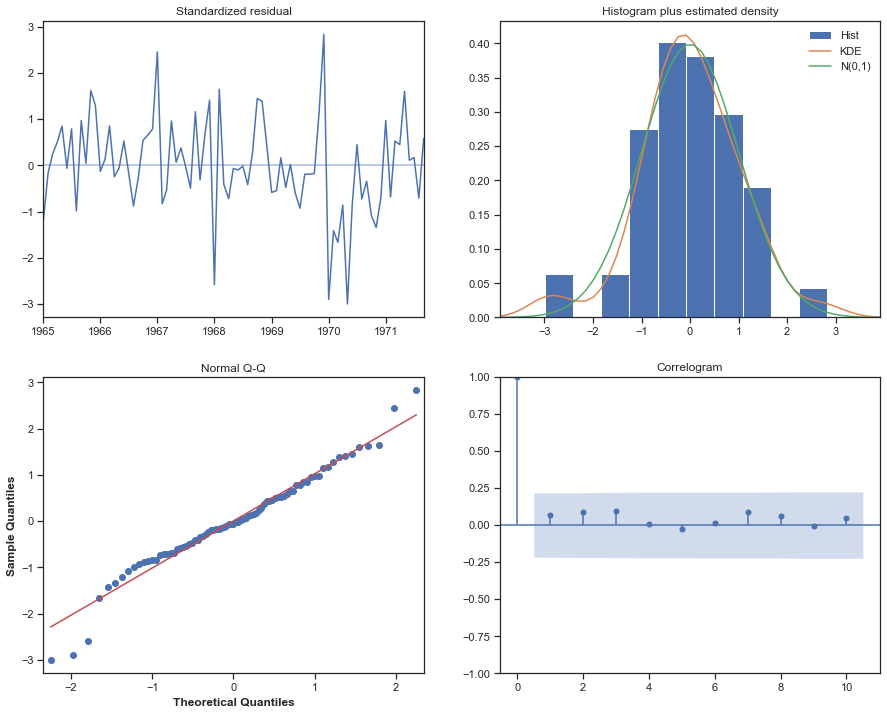

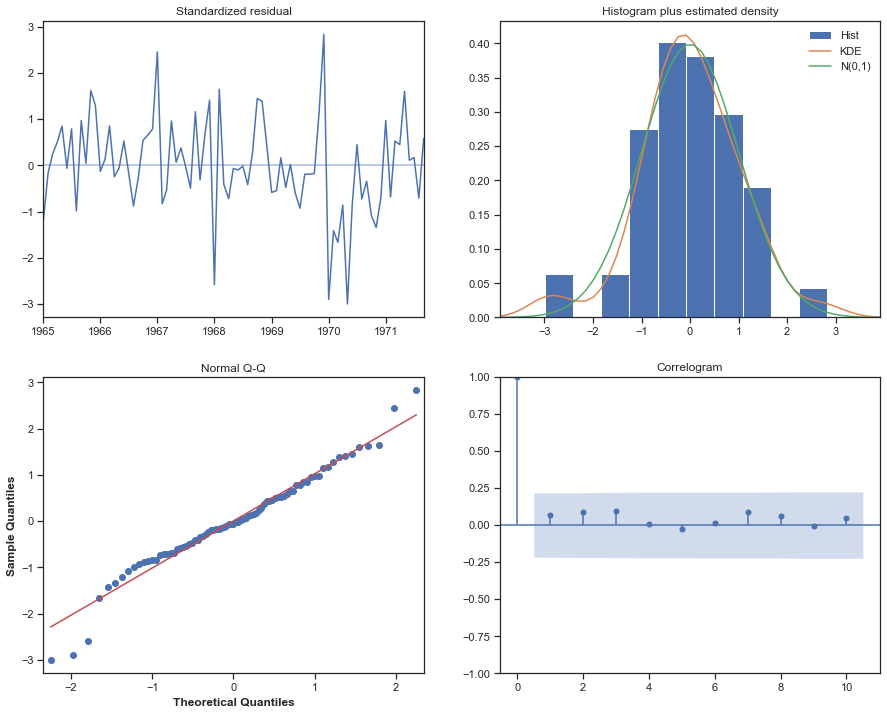

In [7]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
SARIMA_model.plot_diagnostics(figsize=(15,12))
SARIMAX_model.plot_diagnostics(figsize=(15,12))

In [8]:
pred_arima, _, _ = arima_forecast(ARIMA_model, df, periods=df_test.shape[0])
eval_arima = metrics_sklearn(df_test['Sale'].values, pred_arima.values)

pred_sarima, _, _ = arima_forecast(SARIMA_model, df, periods=df_test.shape[0])
eval_sarima = metrics_sklearn(df_test['Sale'].values, pred_sarima.values)

pred_sarimax, _, _ = sarimax_forecast(SARIMAX_model, df, periods=df_test.shape[0])
eval_sarimax = metrics_sklearn(df_test['Sale'].values, pred_sarimax.values)

# plt.figure(figsize=(15,7))
# plt.plot(df['Sale'], color='#1f76b4')
# plt.plot(df_test['Sale'], color='red')
# plt.plot(pred_arima, color='darkgreen')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
# plt.title('ARIMA - Forecast of champagne sales')
# plt.show()

# Deep learning approach

In [9]:
split_date = df_test.index[0]
train, val = series.split_after(pd.Timestamp(split_date))

In [10]:
scaler = Scaler()

train_scaled = scaler.fit_transform(train)
series_scaled, val_scaled = scaler.transform(series), scaler.transform(val)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000), attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)

In [11]:
forecast = df_test.shape[0]

model_lstm = fit_model('LSTM', series_scaled, train_scaled, val_scaled, covariates, seq_len)
pred_lstm = scaler.inverse_transform(model_lstm.predict(n=forecast, future_covariates=covariates))
eval_lstm = metrics_darts(pred_lstm, series)

model_gru = fit_model('GRU', series_scaled, train_scaled, val_scaled, covariates, seq_len)
pred_gru = scaler.inverse_transform(model_gru.predict(n=forecast, future_covariates=covariates))
eval_gru = metrics_darts(pred_gru, series)

model_rnn = fit_model('RNN', series_scaled, train_scaled, val_scaled, covariates, seq_len)
pred_rnn = scaler.inverse_transform(model_rnn.predict(n=forecast, future_covariates=covariates))
eval_rnn = metrics_darts(pred_rnn, series)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

# Evaluation

In [12]:
keys = eval_arima.keys()
d = {'arima':eval_arima,
     'sarima':eval_sarima,
     'sarimax':eval_sarimax,
     'lstm':eval_lstm,
     'gru':eval_gru,
     'rnn':eval_rnn} 

res = pd.DataFrame({k:[i[k] for i in d.values()] for k in keys})
res.index = d.keys()
white = green = [{'selector': 'th', 'props': 'background-color: white'}]
res.style.set_properties(**{'background-color': 'white'}).highlight_min(color='lightgreen').highlight_max(color='red').set_table_styles({k: white for k in res.index}, axis=1)

,mae,mse,rmse,r2_score
arima,1766.904000,9133461.535000,3022.162000,-0.123000
sarima,362.507000,215937.955000,464.691000,0.973000
sarimax,362.507000,215937.955000,464.691000,0.973000
lstm,483.204000,333257.483000,577.285000,0.962000
gru,477.334000,347378.672000,589.388000,0.960000
rnn,490.834000,396862.345000,629.970000,0.954000


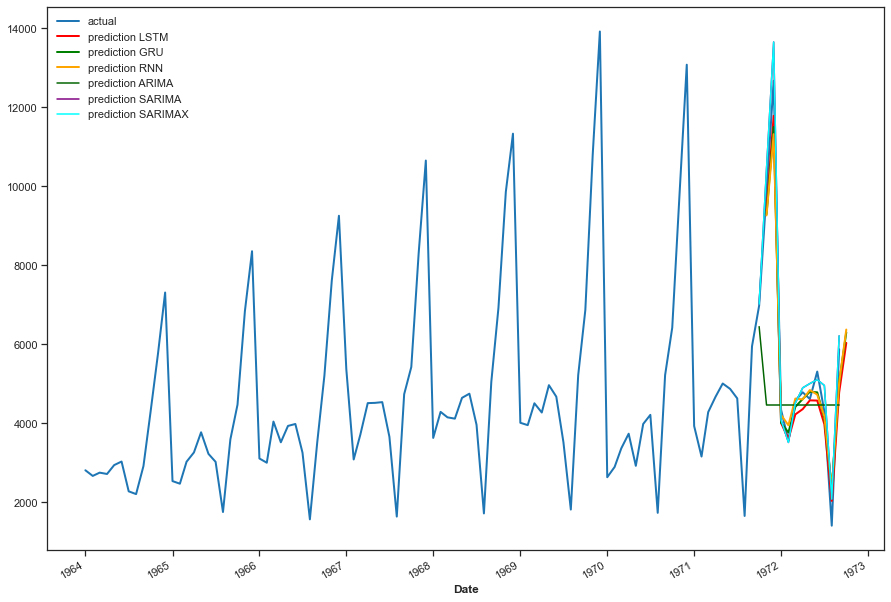

In [13]:
plt.figure(figsize=(15,10))
series.plot(label='actual', color='#1f76b4')
pred_lstm.plot(label='prediction LSTM', color='red')
pred_gru.plot(label='prediction GRU', color='green')
pred_rnn.plot(label='prediction RNN', color='orange')
plt.plot(pred_arima, color='darkgreen', label='prediction ARIMA')
plt.plot(pred_sarima, color='purple', label='prediction SARIMA')
plt.plot(pred_sarimax, color='cyan', label='prediction SARIMAX')
plt.legend()
plt.show()